In [3]:
pip install thermo

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [156]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, rosen, Bounds, differential_evolution, brute
from scipy.constants import calorie, R, atm
import os
import thermo
import matplotlib.pyplot as plt

In [6]:
os.getcwd()

'/root/Molecular_distillation_simulator'

In [7]:
def nrtl(T, alpha1, alpha2, g1, g2, x):
    '''
    NRTLによる活量係数の計算

    Parameters
    ----------
    alpha : ndarray(n,n)
        Array of NRTL nonrandomness parameters. n = the number of 
        components in the system.
    tau : ndarray(n,n)
        Array of NRTL tau parameters. tau[i,i] should be set to 0.
    t : float
        Temperature (K)
    x : ndarray(n,)
        Mole fraction of each component

    Returns
    -------
    gamma : ndarray(n,)
        Activity coefficient of each component    
    '''
    alpha = np.asarray([alpha1, alpha2])
    g = np.asarray([[0, g1],
                  [g2, 0]])
    
    tau = g / (R*T)
    G = np.exp(-(alpha*tau))
    ncomp = x.shape[0]
    gamma = np.zeros_like(x)
    summ = 0
    
    for i in range(ncomp):
        summ = 0
        for j in range(ncomp):
            summ += x[j]*G[i,j]/np.sum(G[:,j]*x)*(tau[i,j] - (np.sum(x*tau[:,j]*G[:,j])/np.sum(G[:,j]*x)))
        gamma[i] = np.sum(tau[:,i]*G[:,i]*x)/np.sum(G[:,i]*x) + summ
        
        return np.exp(gamma)
    
def opt_test():
    T = 138 + 273.15
    g_ini = np.asarray([[0, 1.0],
                    [1.0, 0]])
    tau_ini = g_ini / (R*T)
    alpha_ini = 0.2
    x_ini = np.asarray([0.9898662364, 0.0101337636])
    gamma_ini = nrtl(alpha_ini, tau_ini, x_ini)
    print(gamma_ini)
    
def equilibrium(pi, x, y, p):
    '''
    低圧の気液平衡関係式から活量係数を求める
    '''
    gamma_lab = (pi * y) / (p * x)
    return gamma_lab

def lab_read(pi):
    '''
    実験データの読み取り
    3atm, 5atm, 8atm, 11.2atmそれぞれの圧力条件でのデータ
    '''
    df_lab = pd.read_csv("/root/Molecular_distillation_simulator/table.csv").drop(index=[0, 1]).reset_index().drop(columns="index")
    
    df_atm3 = pd.DataFrame(df_lab.iloc[0:10, 0:4]).set_axis(['No.', 'Liquid phase methanol mole fraction', 
                                                         'Vapor phase methanol mole fraction', 'Temperature [℃]'], axis=1)
    # print(df_atm3)
    df_atm5 = pd.DataFrame(df_lab.iloc[0:11, 4:8]).set_axis(['No.', 'Liquid phase methanol mole fraction', 
                                                         'Vapor phase methanol mole fraction', 'Temperature [℃]'], axis=1)
    # print(df_atm5)
    df_atm8 = pd.DataFrame(df_lab.iloc[12:24, 0:4]).set_axis(['No.', 'Liquid phase methanol mole fraction', 
                                                          'Vapor phase methanol mole fraction', 'Temperature [℃]'], axis=1).reset_index().drop(columns="index")
    # print(df_atm8)
    df_atm11 = pd.DataFrame(df_lab.iloc[12:23, 4:8]).set_axis(['No.', 'Liquid phase methanol mole fraction', 
                                                          'Vapor phase methanol mole fraction', 'Temperature [℃]'], axis=1).reset_index().drop(columns="index")
    # print(df_atm11)
    if pi == 3:
        return df_atm3
    elif pi == 5:
        return df_atm5
    elif pi == 8:
        return df_atm8
    else:
        return df_atm11

In [201]:
#ラボデータ、初期条件
#蒸気圧 ※今後は厳密計算を行う必要がある
num = 8
pi = num * atm
from thermo.vapor_pressure import *
p1 = VaporPressure(CASRN="67-56-1").calculate(T, "ANTOINE_POLING")
p2 = VaporPressure(CASRN="7732-18-5").calculate(T, "ANTOINE_POLING")

df_yx = pd.DataFrame(np.zeros([len(df_lab),4]), columns=['y1x1_cal', 'y2x2_cal', 'y1x1_nrtl', 'y2x2_nrtl'])

for i in range(len(df_lab)):
    df_lab = lab_read(num)
    t = np.float64(df_lab.iloc[i, 3])
    T = t + 273.15

    #ラボデータを用いて計算した活量係数： gamma_lab
    gamma_lab1 = equilibrium(pi, np.float64(df_lab.iloc[i, 1]), np.float64(df_lab.iloc[i, 2]), p1)
    gamma_lab2 = equilibrium(pi, 1 - np.float64(df_lab.iloc[i, 1]), 1 - np.float64(df_lab.iloc[i, 2]), p2)

    #NRTLから計算した活量係数：　gamma_cal
    x_ini = np.asarray([0.2, 0.8])
    #alpha_ini = np.asarray([0.2, 0.2])
    #g_ini = np.asarray([[0, 2022],[1000, 0]])
    alpha_ini1, alpha_ini2, g_ini1, g_ini2 = 0.2, 0.4, -500, -500 # g_iniは適当な初期値

    gamma_cal = nrtl(T, alpha_ini1, alpha_ini2, g_ini1, g_ini2, x_ini)
    #誤差の関数
    #E = np.sqrt((gamma_lab1 - gamma_cal[0])**2) + np.sqrt((gamma_lab2 - gamma_cal[1])**2)
    def E(X):
        #gamma_lab1 = equilibrium(pi, np.float64(df_lab.iloc[i, 1]), np.float64(df_lab.iloc[i, 2]), p1)
        #gamma_lab2 = equilibrium(pi, 1 - np.float64(df_lab.iloc[i, 1]), 1 - np.float64(df_lab.iloc[i, 2]), p2)
        gamma_cal = nrtl(T, X[0], X[1], X[2], X[3], x_ini)
        e = np.sqrt((gamma_lab1 - gamma_cal[0])**2) + np.sqrt((gamma_lab2 - gamma_cal[1])**2)
        return e
    #Eのoptimize
    x0 = [0.20, 0.20, -100, 1000]
    bounds_x1 = (0.20, 0.47)
    bounds_x2 = (0.20, 0.47)
    bounds_x4 = (-5000, 5000)
    bounds_x4 = (-5000, 5000)
    bound = [bounds_x1, bounds_x2, bounds_x3, bounds_x4]
    #bound = [bounds_x1, bounds_x2]
    #fit_x = minimize(E, x0, method="Nelder-Mead", tol=1e-6)
    # fit_x = differential_evolution(E, x0, bound)
    fit_x = differential_evolution(E, bound, x0=x0)
    x_fit = fit_x.x
    gamma_nrtl = nrtl(T, x_fit[0], x_fit[1], x_fit[2], x_fit[3], x_ini)
    # df_yx.iloc[i, 0] = p1 * gamma_lab1 / pi
    # df_yx.iloc[i, 1] = p2 * gamma_lab2 / pi
    # df_yx.iloc[i, 2] = p1 * gamma_nrtl[0] / pi
    # df_yx.iloc[i, 3] = p2 * gamma_nrtl[1] / pi
    
    df_yx.iloc[i, 0] = gamma_lab1
    df_yx.iloc[i, 1] = gamma_lab2
    df_yx.iloc[i, 2] = gamma_nrtl[0]
    df_yx.iloc[i, 3] = gamma_nrtl[1]

In [186]:
nrtl(T, x_fit[0], x_fit[1], x_fit[2], x_fit[3], x_ini)

array([0.97687767, 1.        ])

In [202]:
df_yx

,y1x1_cal,y2x2_cal,y1x1_nrtl,y2x2_nrtl
0,7.314860,4.508241,7.316756,1.0
1,6.138344,4.160144,6.137940,1.0
2,4.965689,3.749954,4.965899,1.0
3,4.324742,3.413847,4.324742,1.0
4,3.429466,3.220650,3.430273,1.0
5,2.860588,3.131020,2.861550,1.0
6,2.476531,3.091770,2.476531,1.0
7,2.133015,2.964210,2.133015,1.0
8,1.949272,2.871925,1.949272,1.0
9,1.813212,2.766944,1.813212,1.0


In [203]:
df_lab

,No.,Liquid phase methanol mole fraction,Vapor phase methanol mole fraction,Temperature [℃]
0,1,0.03,0.143,165.1
1,2,0.058,0.232,161.1
2,3,0.106,0.343,156.2
3,4,0.154,0.434,152.1
4,5,0.23,0.514,148.3
5,6,0.309,0.576,144.9
6,7,0.391,0.631,142
7,8,0.518,0.72,138.3
8,9,0.618,0.785,135.8
9,10,0.716,0.846,133.8


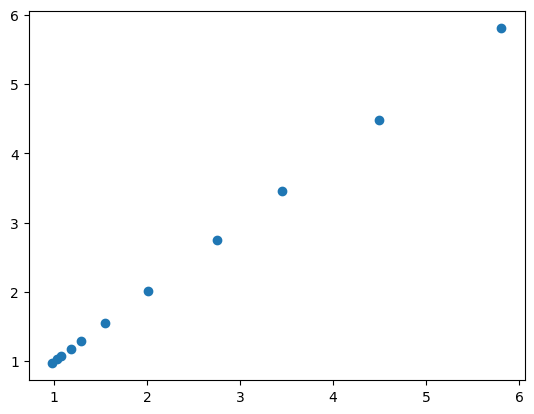

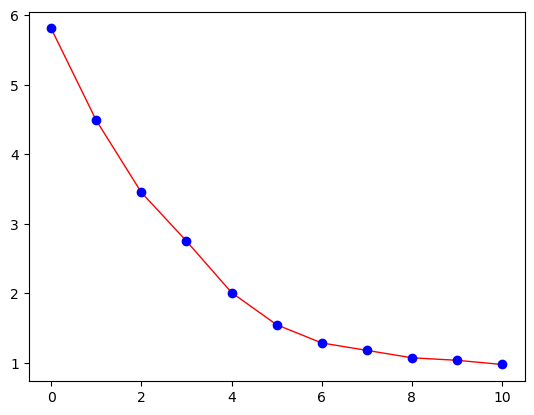

In [199]:
plt.scatter(df_yx["y1x1_cal"], df_yx["y1x1_nrtl"])
plt.show()
plt.plot(range(len(df_lab)), df_yx["y1x1_cal"], "-", color="red", linewidth=1)
plt.plot(range(len(df_lab)), df_yx["y1x1_nrtl"], "o", color="blue")
plt.show()

In [106]:
#grid_fit_x = brute(E, [[0.2,0.47],[0.2,0.47],[]])

In [138]:
gamma_opt = nrtl(T, fit_x.x[0], fit_x.x[1], fit_x.x[2], fit_x.x[3], x_ini)
print(gamma_cal, gamma_opt, [gamma_lab1, gamma_lab2])

[1.00060013 1.        ] [1.44044142 1.        ] [2.040129042278181, 1.0616863144082942]
